In [875]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/SSD/Code/Julia/tinympc-julia/quadrotor_traj_gen/Project.toml`


In [876]:
using LinearAlgebra
using BlockDiagonals
using ForwardDiff
using Plots
using Random
using JuMP
using COSMO
using OSQP
using Printf

In [877]:
#Set up visualization
using TrajOptPlots
using MeshCat
using StaticArrays
using RobotZoo:Quadrotor

vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8726
└ @ MeshCat /home/khai/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8726))

In [878]:
#Quaternion stuff
function hat(v)
    return [0 -v[3] v[2];
            v[3] 0 -v[1];
            -v[2] v[1] 0]
end
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s    -v';
         v  s*I+hat(v)]
    return L
end
T = Diagonal([1; -ones(3)])
H = [zeros(1,3); I]
function qtoQ(q)
    return H'*T*L(q)*T*L(q)*H
end
function G(q)
    G = L(q)*H
end
function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end
function qtorp(q)
    q[2:4]/q[1]
end
function E(q)
    E = BlockDiagonal([1.0*I(3), G(q), 1.0*I(6)])
end

E (generic function with 1 method)

In [879]:
#Quadrotor parameters
m = 0.035
ℓ = 0.046
J = [16.6e-6 0.83e-6 0.72e-6;
    0.83e-6 16.6e-6 1.8e-6;
    0.72e-6 1.8e-6 29.3e-6];
g = 9.81
# thrustToTorque = 0.005964552
thrustToTorque = 0.0008
ℓ = 0.046/sqrt(2)
scale = 65535
kt = 2.245365e-6*scale # u is PWM in range [0...1]
km = kt*thrustToTorque #4.4733e-8

freq1 = 20
h = 1/freq1 #50 Hz

Nx = 13     # number of states (quaternion)
Nx̃ = 12     # number of states (linearized)
Nu = 4     # number of controls
nx = Nx̃
nu = Nu

4

In [880]:
function quad_dynamics(x,u)
  r = x[1:3]
  q = x[4:7]/norm(x[4:7]) #normalize q just to be careful
  v = x[8:10]
  ω = x[11:13]
  Q = qtoQ(q)
  
  ṙ = v
  q̇ = 0.5*L(q)*H*ω
  
  v̇ = [0; 0; -g] + (1/m)*Q*[zeros(2,4); kt*ones(1,4)]*u 

  ω̇ = J\(-hat(ω)*J*ω + [-ℓ*kt -ℓ*kt ℓ*kt ℓ*kt; -ℓ*kt ℓ*kt ℓ*kt -ℓ*kt; -km km -km km]*u)
  
  return [ṙ; q̇; v̇; ω̇]
end
function quad_dynamics_rk4(x,u)
  #RK4 integration with zero-order hold on u
  f1 = quad_dynamics(x, u)
  f2 = quad_dynamics(x + 0.5*h*f1, u)
  f3 = quad_dynamics(x + 0.5*h*f2, u)
  f4 = quad_dynamics(x + h*f3, u)
  xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
  xn[4:7] .= xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
  return xn
end

quad_dynamics_rk4 (generic function with 1 method)

In [881]:
#Goal state
@show uhover = (m*g/kt/4)*ones(4)  # m = 30g and max thrust = 60g
rg = [0.0; 0; 0.0]
qg = [1.0; 0; 0; 0]
vg = zeros(3)
ωg = zeros(3)
xg = [rg; qg; vg; ωg];

uhover = (((m * g) / kt) / 4) * ones(4) = [0.5833333520642209, 0.5833333520642209, 0.5833333520642209, 0.5833333520642209]


In [882]:
#Linearize dynamics about hover
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover),xg)
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(xg,u),uhover);
Ã = Array(E(qg)'*A*E(qg))
B̃ = Array(E(qg)'*B);
function discrete_dynamics(params,x,u,k)
  Ã*x + B̃*u 
end

discrete_dynamics (generic function with 1 method)

In [883]:
# Cost weights
# Saved
# max_dev_x = [0.1; 0.1; 0.1;  0.5; 0.5; 0.05;  0.5; 0.5; 0.5;  0.5; 0.5; 0.1]
# max_dev_u = [0.5; 0.5; 0.5; 0.5]/10
max_dev_x = [0.1; 0.1; 0.1;  0.5; 0.5; 0.03;  0.5; 0.5; 0.5;  0.7; 0.7; 0.2]/10
max_dev_u = [0.5; 0.5; 0.5; 0.5]
Q = diagm(1 ./(max_dev_x.^2))
R = diagm(1 ./(max_dev_u.^2))
Qf = 10*Q

12×12 Matrix{Float64}:
 100000.0       0.0       0.0     0.0  …     0.0     0.0      0.0       0.0
      0.0  100000.0       0.0     0.0        0.0     0.0      0.0       0.0
      0.0       0.0  100000.0     0.0        0.0     0.0      0.0       0.0
      0.0       0.0       0.0  4000.0        0.0     0.0      0.0       0.0
      0.0       0.0       0.0     0.0        0.0     0.0      0.0       0.0
      0.0       0.0       0.0     0.0  …     0.0     0.0      0.0       0.0
      0.0       0.0       0.0     0.0        0.0     0.0      0.0       0.0
      0.0       0.0       0.0     0.0        0.0     0.0      0.0       0.0
      0.0       0.0       0.0     0.0     4000.0     0.0      0.0       0.0
      0.0       0.0       0.0     0.0        0.0  2040.82     0.0       0.0
      0.0       0.0       0.0     0.0  …     0.0     0.0   2040.82      0.0
      0.0       0.0       0.0     0.0        0.0     0.0      0.0   25000.0

In [884]:
#Feedback tracking controller
include("tinyMPC.jl")
include("mpc_JuMP.jl")
dt = 1/freq1
Tfinal = 20.0 # final time
Nt = Int(Tfinal/dt)+1    # number of time steps
N = Nt
Nh = Nt
t_vec = h*(0:Nt-1)

#Create trajectory to follow
Xref = [[zeros(3); 1; zeros(9)] for i = 1:Nt]
Δx̃ref = [zeros(nx) for i = 1:Nt]
ΔUref = [zeros(nu) for i = 1:Nt-1]

## Hovering
# Xref = [xg for i = 1:Nt]

## Number-eight
# Xref = [[1*cos(t)*sin(t);1*cos(t);1;1;zeros(9)] for t = range(-pi/2, 3*pi/2, length = Nt)]  

## Fast circle
radius = 1.2
Xref = [[radius*cos(t); radius*sin(t); 1; 1; zeros(9)] for t = range(-pi/2, 3*pi/2+2*pi, length = Nt)]  

# Triangle
# p0 = [0; 0; 1.0]; p1 = [3; 4; 1.]; p2 = [0; 8; 1.]; p3 = [0; 0; 1.0]
# range1 = collect(LinRange(p0, p1, round(Int,(Nt)/3)))
# range2 = collect(LinRange(p1, p2, round(Int,(Nt)/3)))
# range3 = collect(LinRange(p2, p3, round(Int,(Nt)/3)+1))
# range123 = [range1; range2; range3]
# for k = 1:Nt
#     Xref[k][1:3] .= range123[k]
# end

## Square
# p0 = [0; 0; 1]; p1 = [2; 0; 1]; p2 = [2; 2; 1]; p3 = [0; 2; 1]
# range1 = collect(LinRange(p0, p1, round(Int,(Nt)/4)))
# range2 = collect(LinRange(p1, p2, round(Int,(Nt)/4)))
# range3 = collect(LinRange(p2, p3, round(Int,(Nt)/4)))
# range4 = collect(LinRange(p3, p0, round(Int,(Nt)/4)+1))
# range1234 = [range1; range2; range3; range4]
# for k = 1:Nt
#     Xref[k][1:3] .= range1234[k]
# end

## Vertical Circular Flip 
# p0 = [0; 0; 1; 1; 0; 0; 0]; 
# p1 = [0; 0.5; 1.5; 0.7071068; 0.7071068; 0; 0]; p2 = [0; 0; 2; 0; 1; 0; 0]; 
# p3 = [0; -0.5; 1.5; -0.7071068; 0.7071068; 0; 0]; p4 = [0; 0; 1; 1; 0; 0; 0];
# range1 = collect(LinRange(p0, p1, round(Int,(Nt)/4)))
# range2 = collect(LinRange(p1, p2, round(Int,(Nt)/4)))
# range3 = collect(LinRange(p2, p3, round(Int,(Nt)/4)))
# range4 = collect(LinRange(p3, p4, round(Int,(Nt)/4)+1))
# range1234 = [range1; range2; range3; range4]
# for k = 1:Nt
#     Xref[k][1:7] .= range1234[k]
#     Xref[k][4:7] .= Xref[k][4:7]/norm(Xref[k][4:7])
# end
# p0 = [0; 0; 1; 1; 0; 0; 0];
# p1 = [-1; -1; 1; 0.7071068; 0; 0.7071068; 0]; p2 = [0; -2; 1; 1; 0; 0; 0]; 
# range1 = collect(LinRange(p0, p1, round(Int,(Nt)/2)))
# range2 = collect(LinRange(p1, p2, round(Int,(Nt)/2)+1))
# range1234 = [range1; range2]
# for k = 1:Nt 
#     Xref[k][1:7] .= range1234[k]
#     Xref[k][4:7] .= Xref[k][4:7]/norm(Xref[k][4:7])
# end

# Velocity reference: speeds up the tracking but less smooth
for i = 1:Nt-1
    Xref[i][8:10] = (Xref[i+1][1:3] - Xref[i][1:3])/dt
end
for k = 1:Nt
    x = Xref[k]
    q = x[4:7]
    ϕ = qtorp(L(qg)'*q)   
    Δx̃ref[k] .= [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
end  

optimizer = JuMP.optimizer_with_attributes(OSQP.Optimizer,
        "verbose"=>false,
        "eps_abs"=>1e-3,
        "eps_rel"=>1e-3,
        "eps_prim_inf"=>1e-3,
        "eps_dual_inf"=>1e-3,
        "max_iter"=>1000)
        # "rho"=>1e-2,
        # "scaling"=>0,
        # "alpha"=>1.0,)  

model = Model(optimizer)

u_min = -uhover + 0.1*[1; 1; 1; 1]
u_max =  0.9*[1; 1; 1; 1] - uhover

# state is x y v θ
x_min = -100*ones(nx)
x_min[3] = -0.2
x_max = 100*ones(nx)
x_max[3] = 0.2

# previous MPC iterate
X = [zeros(nx) for i = 1:N]
X[1][1:3] .= Xref[1][1:3]
U = [uhover for k = 1:N-1]

params = (
    nx = nx, nu = nu, ncx = 0, ncu = 1, ncg = 1, ncu_cone = 0,
    N = N, Q = Q, R = R, Qf = Qf,
    u_min = u_min, u_max = u_max,
    x_min = x_min, x_max = x_max,
    Xref = Δx̃ref, Uref = ΔUref, dt = dt, cache = cache
);

u = mpc_JuMP!(optimizer, params, X, U, Ã, B̃, 0.0; warm_start=true)

  0.047368 seconds (230.82 k allocations: 25.870 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


4-element Vector{Float64}:
  0.1894761429035577
 -0.16011491408982548
  0.08621371729877841
 -0.09285776405885082

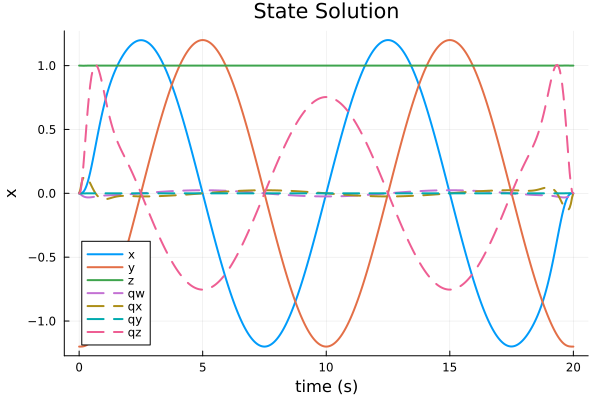

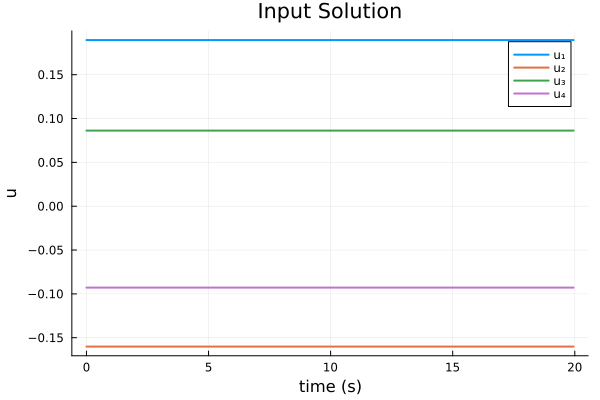

In [885]:
# Plots
Xsim_m = mat_from_vec(X)
Usim_m = mat_from_vec(U)
display(plot(t_vec,Xsim_m[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State Solution", xlabel="time (s)", ylabel="x"))
display(plot(t_vec[1:end-1],Usim_m',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input Solution", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))

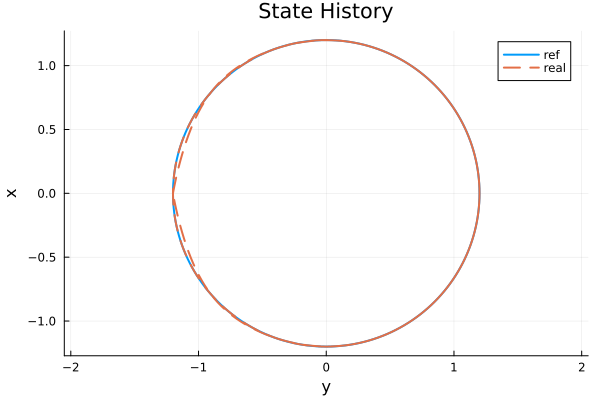

In [886]:
Xsim_m = mat_from_vec(Xref[1:N])
plot(Xsim_m[2,:],Xsim_m[1,:],label="ref",
linestyle=:solid, linewidth=2,
             title="State History", xlabel="y", ylabel="x")
Xsim_m = mat_from_vec(X[1:N])   
display(plot!(Xsim_m[2,:],Xsim_m[1,:],label="real", linestyle=:dash, linewidth=2,
             title="State History", xlabel="y", ylabel="x", aspect_ratio=:equal))

In [887]:
model = Quadrotor()
TrajOptPlots.set_mesh!(vis, model)
X1 = [zeros(13) for i = 1:Nt]
for k = 1:Nt
  x = 1*X[k]
  ϕ = 1*x[4:6]
  qq = 1*rptoq(ϕ)
  X1[k] .= [x[1:3]+rg; qq; x[7:9]+vg; x[10:12]+ωg]
end  
X2 = [SVector{13}(x) for x in X1];
visualize!(vis, model, t_vec[end], X2)

In [888]:
X_ref_data = [X[i][1:nx] for i = 1:Nt]
interpl_step = Int(300/freq1)
X_ref_data1 = [zeros(nx) for i = 1:(Nt)*interpl_step]
for k = 1:Nt-1
  X_ref_data1[((k-1)*interpl_step+1):k*interpl_step] .= collect(LinRange(X_ref_data[k], X_ref_data[k+1], interpl_step+1))[1:interpl_step]
end
X_ref_data1[((Nt-1)*interpl_step+1):Nt*interpl_step] .= X_ref_data1[((Nt-2)*interpl_step+1):(Nt-1)*interpl_step]

# Export a vector of vectors to C header and source 
function export_vec_to_c(filename, var_type, var_name, data)
  declare = var_type * " " * var_name
  def = declare * " = {\n"
  for i=1:length(data)
      def = def * "  "
      for j=1:length(data[1])
          def = def * @sprintf("%.4f", data[i][j])
          if j < length(data[1]) 
              def = def * ","
          end
      end
      if i < length(data)
          def = def * ",\n"
      end
  end
  def = def*"}"

  open(filename*".h","a") do io
          println(io, def * ";\n")
  end
  return true
end
export_vec_to_c("data", "static const float", "X_ref_data[]", X_ref_data1)

true

In [889]:
U_ref_data = [U[i][1:nu] for i = 1:Nt-1]
U_ref_data1 = [zeros(nx) for i = 1:(Nt-1)*interpl_step]
for k = 1:Nt-2
  U_ref_data1[(k-1)*interpl_step+1:k*interpl_step] .= collect(LinRange(U_ref_data[k], U_ref_data[k+1], interpl_step+1))[1:interpl_step]
end
export_vec_to_c("data", "static const float", "U_ref_data[]", U_ref_data1)

true